# Extract-Transform-Load (ETL), Analysis, and Visualization of Monthly Retail Trade Survey Data 

**WILLY GIOVANNI BERNAL HEREDIA**

# Index

- [Abstract](#Abstract)
- [1. Introduction](#1.-Introduction)
- [2. Extract-Transform-Load](#2.-Extract-Transform-Load)
    - [2.1 The ETL Process](#2.1-The-ETL-Process)
    - [2.2 Data Exploration](#2.2-Data-Exploration)
    - [2.3 Data Preparation](#2.3-Data-Preparation)
    - [2.4 Read the Data Using Python](#2.4-Reading-the-Data-Using-Python)
         - [2.4.1 Reading Sample Data](#2.4.1-Reading-Sample-Data)
         - [2.4.2 Reading the MRST Data](#2.4.2-Reading-the-MRST-Data)
    - [2.5 Writing an Installation Script](#2.5-Writing-an-Installation-Script)
- [3. Analysis and Visualization](#3.-Project-Description)
    - [3.1 Running Queries in MySQL Workbech](#3.1-Running-Queries-in-MySQL-Workbech)
    - [3.2 Running Queries From Python](#3.2-Running-Queries-From-Python)
    - [3.3 Explore Trends](#3.3-Explore-Trends)
    - [3.4 Explore Percentage Change](#3.4-Explore-Percentage-Change)
    - [3.5 Explore Rolling Time Windows](#3.5-Explore-Rolling-Time-Windows)
- [Conclusion](#Conclusion)
- [References](#References)

[Back to top](#Index)


##  Abstract

This report analyzes the Monthly Retail Trade Survey data. As the most comprehensive data available on retail economic activity in the United States, it can be used to infer trends and conclusions of the US economy. The report describes in detail the steps for performing ETL (Extract, Transform, and Load), analysis, and visualization of that data. The efforts  provide a detailed example of the multiple steps required for data analysis. The document also contains insighful results and conclusions about the data.   

[Back to top](#Index)


## 1. Introduction

The Monthly Retail Trade Survey data is the most comprehensive data available on retail economic activity in the United States. This data is provided for multiple categories of commerce. For example, we have monthly sales values for the clothing and clothing accessories stores. The data provides trends on economic activity that can be leveraged to discover and visualize seasonal patterns, trends, and quantify changes in the economic activity.

This report describes the steps for performing ETL (Extract, Transform, and Load), analysis, and visualization for this data set. ETL is critical for digesting, processing, transforming, and making available the data for end-user consumption, visualization, or analysis. That process is called ETL and stands for Extract, Transform, and Load. This process is in charged of getting the data ready and available for data scientists, data analysts, and end-users.

During the Extraction process, data was acquired in its raw format (xls). We saved each worksheet from the excel file manually as a .csv file. A Python script was used to parse the csv files, remove the unnecessary lines, and concatenate the values from multiple years. That process was performed leveraging the pandas and csv libraries. A single file was produced with all relevant information. The data structure of the file will be explained in more detail in the following sections. The cleaning of the data was achieved through Python with the existing powerful libraries for parsing, manipulating, and cleaning the data (e.g., csv, pandas, numpy). 

The clean data was uploaded to mysql using the mysql.connector driver. This step involved creating a database programmatically and inserting data into the newly-created schema. We verified through multiple queries that the data was appropietly uploaded to a table in the database.

The next step consisted of data analysis. This step involved pulling data through mysql queries to calculating trends and patterns from the mysql data. Finally, the last step was to visualize the data by leveraging the plotting libraries in Python (e.g., Matplotlib). We provide the results and conclusions of our analysis in this document.

[Back to top](#Index)

## 2. Extract-Transform-Load

Each of the sections below includes a description of the steps followed. Whenever possible, screenshots of the code or program windows are shown.

[Back to top](#Index)

### 2.1 The ETL Process

ETL stands for Extract, Transform, and Load. This process is in charged of getting the data ready and available for data scientists, data analysts, and end-users. A script is preferable for automated, fast, and reliable operation to process the data. 

During the Extraction process, data was given as an excel file (.xls) with multiple worksheets. Each worksheet was saved into a comma-separated value (.csv) file manually. CSV files are easier to read by Python as they are text-based. After that, a Python script was used to automate the following steps: 

- The files were read programmatically and specific lines were not written into a new file: The lines before the header were removed, and anything after the lines that matched "ADJUSTED (2)" were removed in Python. We only used non-adjusted data from the spreadsheet. According to the documentation, adjusted data has been modified to account for seasonal, holiday, and trading-day differences. The code for this step is shown below:

```python
# Get All Files
file_list = [f"mrtssales_{i}.csv" for i in range(1992,2021,1)]
data_path = "raw_data"
file_list = [os.path.join(data_path, file) for file in file_list]
file_trim_list = list()

# Clean File
for file in file_list:
    with open(file,'r') as csv_file:
        # read line of files
        csv_reader = csv.reader(csv_file, delimiter=',')
        # store headers and rows
        for i in range(4):
            next(csv_reader)
        # New Clean File
        file_trim = file.replace('.csv','_clean.csv')
        file_trim_list.append(file_clean)
        with open(file_clean,'w') as csv_write:
            # create the csv writer
            writer = csv.writer(csv_write,lineterminator='\n')
            # loop through data
            
            for row in csv_reader:
                if "ADJUSTED(2)" in row:
                    break
                elif "NOT ADJUSTED" in row:
                    continue
                else:
                    # write a row to the csv file
                    writer.writerow(row)
```

- The trimmed files were read and parsed as a DataFrame. All rows with NaN or (S) were removed. (S) stands for Supressed and it was removed as it did not meet publication standards. Data was not available for those entries. Also, empty columns and the total column was removed; those values can be calculated, so it is redundant information that should be removed before storage. The code below shows the data cleaning process 

```python
# Init list to save the raw dataframes for each trimmed file
df_raw_list = list()
# Columns to be removed
remove_column = ['Unnamed: 0','Unnamed: 15','Unnamed: 16', 'TOTAL']

# For each Trimmed File
for file in file_trim_list:
    # Read DataFrame
    df_raw = pd.read_csv(file)
    # Remove Unncessary Columns
    rem_col = list(set(df_raw.columns) & set(remove_column))
    df_raw = df_raw.drop(rem_col,axis=1)
    # Rename Columns
    df_raw.rename(columns = {'Unnamed: 1':'Kind'}, inplace = True)
    # Remove ",","'","(S)"
    df_raw.replace(',','', regex=True, inplace=True)
    df_raw.replace("'","", regex=True, inplace=True)
    df_raw.replace('(S)', np.nan, inplace=True)
    # Reset Index
    # Transpose the dataframe to have Date as a column
    df_raw = df_raw.reset_index(drop=True).T
    df_raw.columns = df_raw.iloc[0,:]
    df_raw = df_raw.drop('Kind',axis=0)
    df_raw['Date'] =  pd.to_datetime(df_raw.index)
    df_raw.reset_index(drop=True, inplace=True)
    # Append all dataframes into a list
    df_raw_list.append(df_raw)
```

- The multiple DataFrames were concatenated using the concat function. The final file was saved as a csv. It contains all data for 1992 to 2020 (2021 was not included as it was incomplete). To reduce the length of the columns names, we transform the original names to Camel Case. The code for concatenation, renaming of the columns, removing NaN values, and saving of the resulting dataframe is shown next:

```python
# Concatenate all DataFrames
df = df_raw_list[0]
for d in df_raw_list[1:]:
    df = pd.concat([df, d], axis=0)

# Generate Camel Case
df.columns = [col.title().replace(' ','').replace('(','').replace(')','').replace('-','').replace('.','') for col in df.columns]

# Remove NaN
df.replace('(NA)', np.nan, inplace=True)
df.dropna(axis=1,inplace=True)
# Reset Index
df.reset_index(drop=True,inplace=True)
    
# Save CSV
df.to_csv('data_agg.csv',index=False)
```

To make things easier before putting into the database, the data was transposed: the columns correspond to each of the commerce categories and each row corresponds to a month. It is more logical to have the date as a column; this is the default way of representing chronological data. The following graph shows that structure.

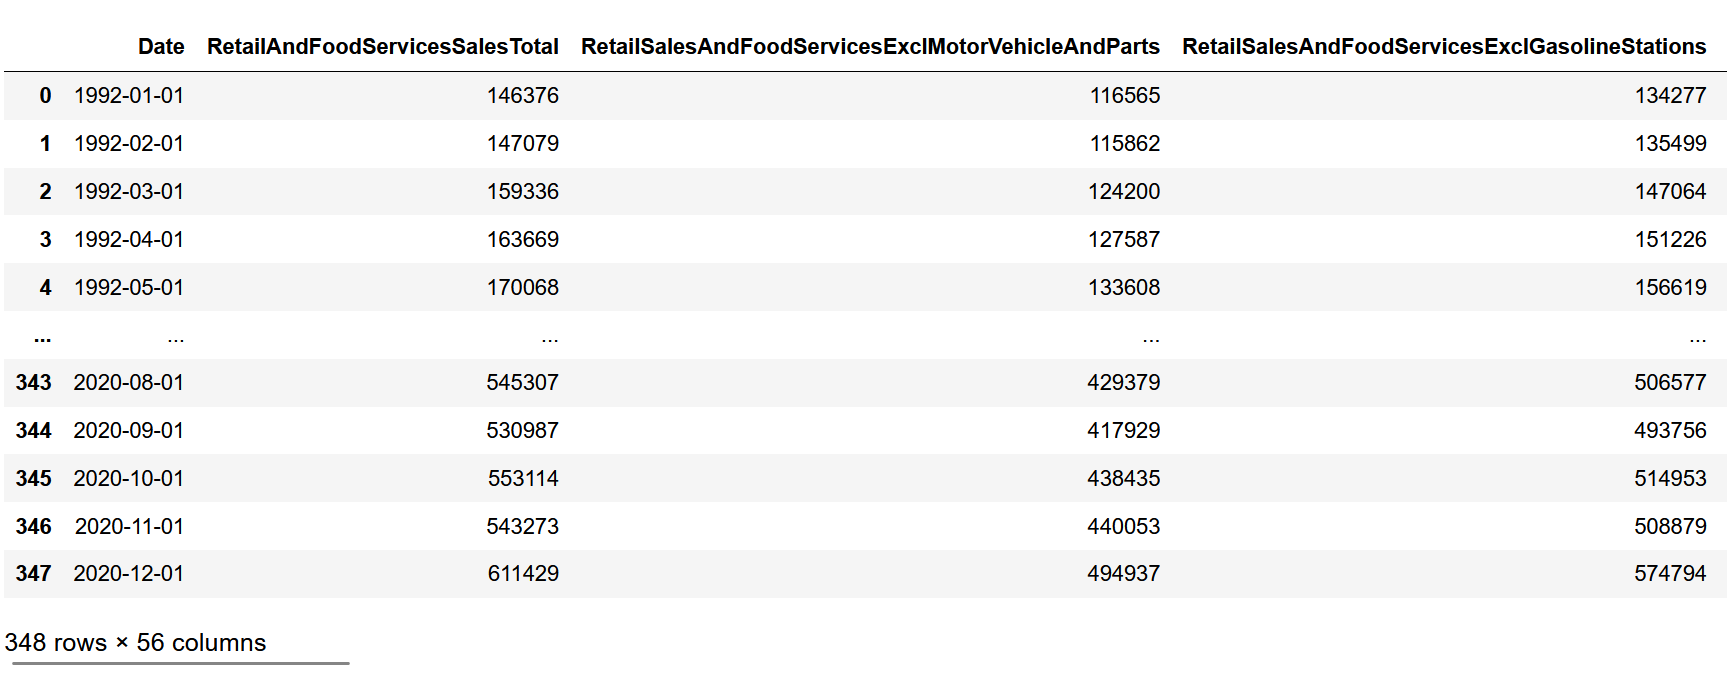

The advantages of an integrated approach for ETL are: 1) less error-prone due to automation, 2) process is easily reusable with minor modifications, 3) the steps are clearly delimited and are highly modular.


The challenging part for me was determining the goal of my project. The information we are trying to obtain at the end determines the data structure (e.g., columns and rows). Also, I found very difficult understanding how to concatenate all information from the multiple years. I was debating whether I should make the date a column and set the Type of Business as the headers. That is not the way the data is originally given in the spreadsheet. I decided to do that as that is more intuitive for the user and consumer of data.

[Back to top](#Index)

### 2.2 Data Exploration

The Monthly Retail Trade Survey data is the most comprehensive data available on retail economic activity in the United States. This data is provided for multiple categories of commerce. For example, we have monthly sales values for the automobile dealers or furnitture stores. The data provides trends on economic activity that can be leveraged to discover and visualize seasonal patterns, trends, and quantify changes in the economic activity. The data contains the NAICS Code and the kind of business. The NAICS code stands for "North American Industry Classification System."

The data contains 65 rows, one for each category of economic activity. The columns correspond to a month of the year. The source file contains data from 1992. We are only considering data until the end of 2020 as data from 2021 is not complete. There is missing data and is labeled as "(S)", which stands for "Supressed": there was no enough confidence in the data to include it in the records. All sales values are provided as intergers and are shown in millions of dollars.

A graph showing the total monthly sales for retail and food services is shown in the graph below. It contains data from 1992 to 2020.

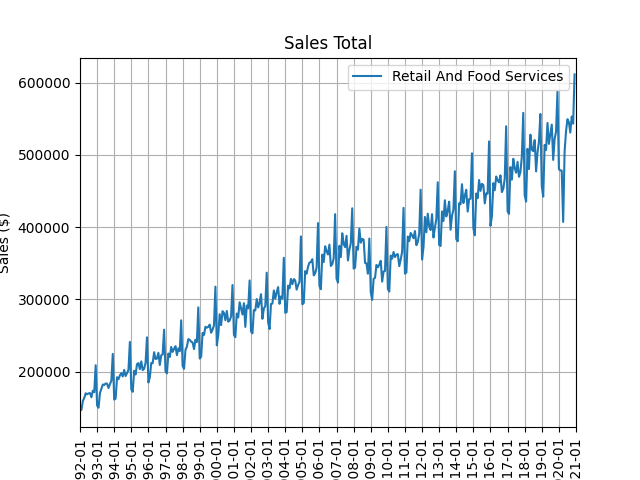


[Back to top](#Index)

### 2.3 Data Preparation

Data was trimmed and cleaned for easy analysis. The lines above the headers were removed and only the not adjusted data is being used. Adjusted data has been modified to account for seasonal, holiday, and trading-day differences, but not for price changes.

The following columns were removed:
- "NAICS Code": this shows the type of business. This was not necessary as we could keep the "kind of business" column.
- "TOTAL": summation of sales per business category per year. This was removed as it can be calculated from the remaining data. The "TOTAL" data was used to verify that the ETL process did not introduce errors into the data. The recorded total values were matched against the calculated ones.
- Any empty columns introduced at the time of saving the file as a CSV document.

The data from each year was concatenated to generate a single dataframe. Then, all missing values or (S) entries were replaced by NaNs. Any business category that contained NaN values were removed. This was an strategic decision as only a few of them would be dropped. All remaining data was complete. The code below shows how the NaN values were dropped, after that the index needed to be reset.

```python
# Remove NaN
df.replace('(NA)', np.nan, inplace=True)
df.dropna(axis=1,inplace=True)
# Reset Index
df.reset_index(drop=True,inplace=True)
```

THe column names were modified and shortened: characters needed to be removed so they can be mysql column names. This was achieved through the following:

```python
# Generate Camel Case
df.columns = [col.title().replace(' ','').replace('(','').replace(')','').replace('-','').replace('.','') for col in df.columns]
```

Finally, the data was transposed: each row corresponds to a month in the year (e.g., '1992-01'). This is more intuitive and lends itself for easy loading into the database.

[Back to top](#Index)

### 2.4 Read the Data Using Python

Python features the csv library that can be used to read CSV files. The syntax used is the following:

```python
# Import CSV library
import csv

# Open File
with open(file,'r') as csv_file:
    # read line of files
    csv_reader = csv.reader(csv_file, delimiter=',')
    # Print lines
    for row in csv_reader:
        print(row)
```

Each row can be printed, modified, or written into another file. In my data preparation, unnecessary lines were removed and a new file was written with the remaining lines. Data was written in the following manner:

```python
with open(file_trim,'w') as csv_write:
    # create the csv writer
    writer = csv.writer(csv_write,lineterminator='\n')
    # write line
    writer.writerow(row)
```

[Back to top](#Index)

### 2.4.1 Reading Sample Data
I used a modified and smaller version of the MRTS data. The table below shows the selected sample data ("sample_file.csv"). This contains 4 businesses and historical data for 4 months. 

| Kind      | Jan. 2020 | Feb. 2020 |Mar. 2020   |	Apr. 2020|
| --------- | --------- | --------- |----------- | --------- |
| Business1 | 480301    | 478467    | 478267	 |407227	 |
| Business2 | 386934    | 380639    | 395880	 |337693	 |
| Business3 | 440605    | 441504    | 444006	 |380417	 |
| Business4 | 347238    | 343676    | 430527	 |377210	 |

During the ETL process, two different ways of reading csv files were used. Each one was used for a different stage of the data preparation. 

1. Using the csv library: This would open the file and read line by line of the text file. The code used for this is shown below.

```python
# Import CSV library
import csv

# Open File
with open('sample_file.csv','r') as csv_file:
    # read line of files
    csv_reader = csv.reader(csv_file, delimiter=',')
    # Print lines
    for row in csv_reader:
        print(row)
```
2. Using the pandas library: the pandas library parses the .csv file into a dataframe. That dataframe will have "Kind" and the four months as columns. This works very well for properly structure data in matrix form. The code used for reading a csv file into a dataframe is included below.

```python
# import pandas
import pandas as pd

# read into dataframe
df = pd.read_csv('sample_file.csv')
```

[Back to top](#Index)

### 2.4.2 Reading the MRTS Data
During the Extraction process, data was given as an excel file (.xls) with multiple worksheets. Each worksheet was saved into a comma-separated value (.csv) file manually. CSV files are easier to read by Python as they are text-based. After that, a Python script was used to automate the following steps: 

- The files were read programmatically and specific lines were not written into a new and clean file: The lines before the header were removed, and anything after the lines that matched "ADJUSTED (2)" were removed in Python. Adjusted data has been modified to account for seasonal, holiday, and trading-day differences, but not for price changes. The code below shows the code for this step.

```python
# Get All Files
file_list = [f"mrtssales_{i}.csv" for i in range(1992,2021,1)]
data_path = "raw_data"
file_list = [os.path.join(data_path, file) for file in file_list]
file_clean_list = list()

# Clean File
for file in file_list:
    with open(file,'r') as csv_file:
        # read line of files
        csv_reader = csv.reader(csv_file, delimiter=',')
        # store headers and rows
        for i in range(4):
            next(csv_reader)
        # New Clean File
        file_clean = file.replace('.csv','_clean.csv')
        file_clean_list.append(file_clean)
        with open(file_clean,'w') as csv_write:
            # create the csv writer
            writer = csv.writer(csv_write,lineterminator='\n')
            # loop through data
            
            for row in csv_reader:
                if "ADJUSTED(2)" in row:
                    break
                elif "NOT ADJUSTED" in row:
                    continue
                else:
                    # write a row to the csv file
                    writer.writerow(row)
```

- The trimmed files were read and parsed as a DataFrame. All rows with NaN or (S) were removed. (S) stands for Supressed and it was removed as it did not meet publication standards. Data was not available for those entries. Also, empty columns and the total column was removed; those values can be calculated, so it is redundant information that should be removed before storage. The code below shows the data cleaning process: 

```python
# Init list to save the raw dataframes for each trimmed file
df_raw_list = list()
# Columns to be removed
remove_column = ['Unnamed: 0','Unnamed: 15','Unnamed: 16', 'TOTAL']

# For each Trimmed File
for file in file_trim_list:
    # Read DataFrame
    df_raw = pd.read_csv(file)
    # Remove Unncessary Columns
    rem_col = list(set(df_raw.columns) & set(remove_column))
    df_raw = df_raw.drop(rem_col,axis=1)
    # Rename Columns
    df_raw.rename(columns = {'Unnamed: 1':'Kind'}, inplace = True)
    # Remove ",","'","(S)"
    df_raw.replace(',','', regex=True, inplace=True)
    df_raw.replace("'","", regex=True, inplace=True)
    df_raw.replace('(S)', np.nan, inplace=True)
    # Reset index and 
    df_raw = df_raw.reset_index(drop=True)
    # Transpose DataFrame
    df_raw = df_raw.T
    # Fix index
    df_raw.columns = df_raw.iloc[0,:]
    df_raw = df_raw.drop('Kind',axis=0)
    # Convert Date column to datetime
    df_raw['Date'] =  pd.to_datetime(df_raw.index)
    df_raw.reset_index(drop=True, inplace=True)
    # Append all dataframes into list
    df_raw_list.append(df_raw)
```

- The multiple DataFrames (saved in **df_raw_list**) were concatenated using the concat function. The final file was saved as a csv. It contains all data for 1992 to 2020 (2021 was not included as it was incomplete). To reduce the length of the columns names, we transform the original names to Camel Case; we removed the spaces and capitalized every word. The following snipped of code implements concatenation, renaming of the columns, replacing any non-value with NaNs, and saving the resulting dataframe:

```python
# Concatenate all DataFrames
df = df_raw_list[0]
for d in df_raw_list[1:]:
    df = pd.concat([df, d], axis=0)

# Generate Camel Case
df.columns = [col.title().replace(' ','').replace('(','').replace(')','').replace('-','').replace('.','') for col in df.columns]

# Any missing values filled with NaN
df.replace('(NA)', np.nan, inplace=True)
# Reset Index
df.reset_index(drop=True,inplace=True)
    
# Save CSV
df.to_csv('data_agg.csv',index=False)
```

To make things easier before putting information into the database, the data was transposed: the columns correspond to each of the commerce categories and each row corresponds to a month. It is more logical to have the date as a column; this is the default way of representing chronological data. The following graph shows the final structure of the data.

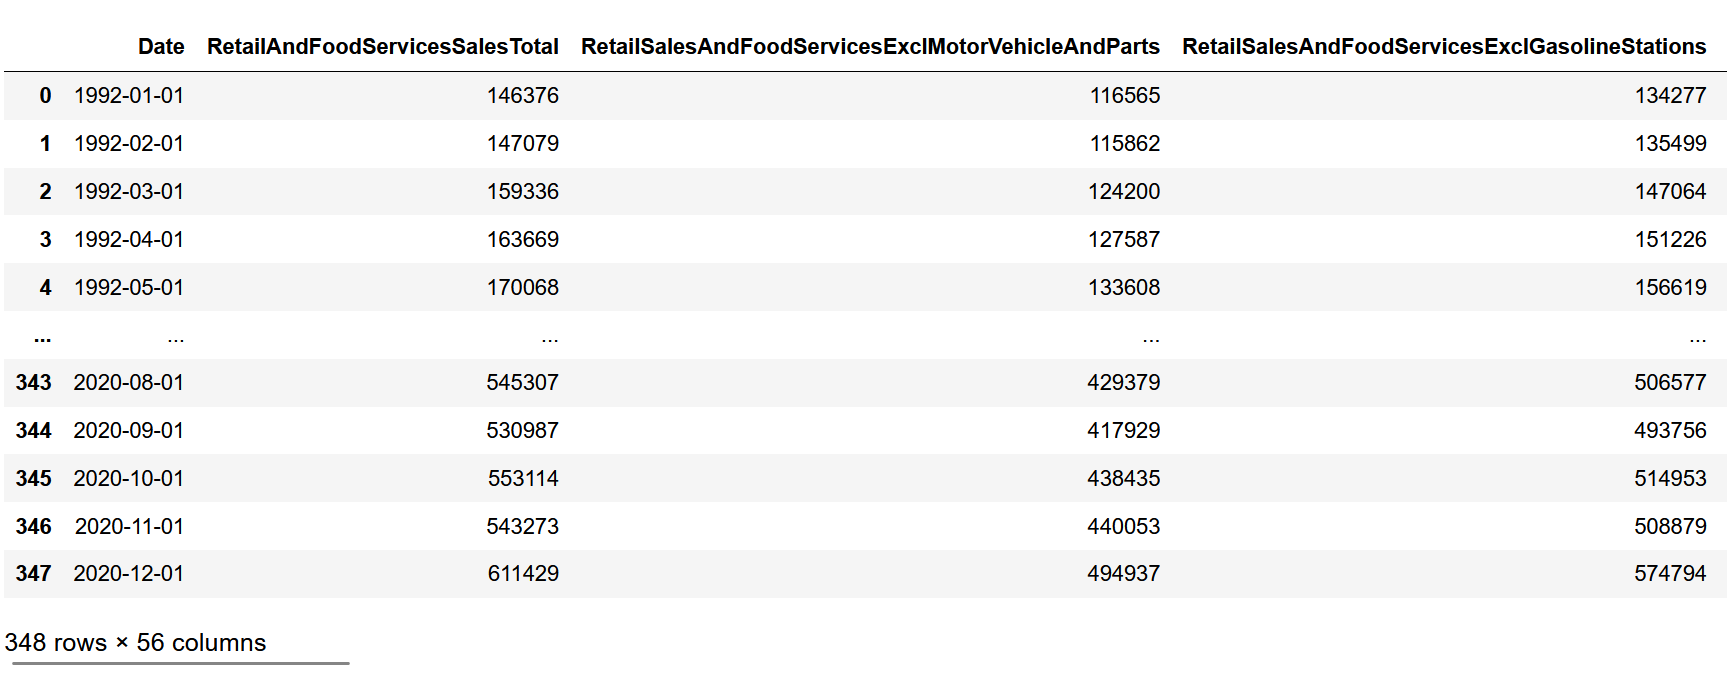

[Back to top](#Index)

### 2.5 Writing an Installation Script

The installation script was written using the **mysql.connector** in python. A connection was open and queries were defined and send to the mysql server. The steps used for the installation script are presented next:

1. Import necessary libraries: we import the mysql.connector driver to connect to the mysql server. 

```python
import mysql.connector 
```

2. Authentication: The credentials to access the mysql server are stored in a yaml file to separate them from the code. This provides enhanced security to the program. The credentials.yaml contains the authentication credentials and mysql server settings.

```python
# Credentials
db = yaml.safe_load(open('credentials.yaml'))
config = {
    'user':     db['database']['user'],
    'password': db['database']['pwrd'],
    'host':     db['database']['host'],
    'database': db['database']['db'],
    'auth_plugin': 'mysql_native_password'
}
```

3. Set up the connection: Connect to the server and pass the authentication information

```python
# Set Up DB Connection
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()
```

4. Create Schema: This step removes the database if it already exits. It creates a new database and selects the newly-created database. All tables created after that will be part of that database.

```python
# Remove database if it already exists
query_cmd = ("DROP SCHEMA IF EXISTS mrtssales;")
# Query Execution
cursor.execute(query_cmd)

#Create new schema
query_cmd = ("CREATE SCHEMA mrtssales;")
# Query Execution
cursor.execute(query_cmd)

# Use newly-created schema
query_cmd = ("USE mrtssales;")
# Query Execution
cursor.execute(query_cmd)
```

5. Create Table: The structure of the table is passed. This includes defining the column names, the type of variable, and other characteristics of the columns (e.g., constraints). We are using the name of the type of business (e.g., MiscellaneousStoreRetailers) as the columns' names. 

```python
# Create Table
query_cmd = "CREATE TABLE sales (sales_id SMALLINT UNSIGNED NOT NULL AUTO_INCREMENT, date DATE NOT NULL,"
for name in df.columns[1:]:
    query_cmd = query_cmd + name[:60] + ' INT,'
query_cmd = query_cmd + "PRIMARY KEY  (sales_id)) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;"
# Execute query
cursor.execute(query_cmd)
```

6. Populate Table: Insert each row of data at a time. The dataframe we generated in the reading phase was used to populate the table. The date column was populated using the months of the year (e.g., '2020-01' for Jan. 2020). The other columns correspond to the different types of business and they contain the monthly sales for that category. 

```python
# Insert Values
for i in range(0,len(df)): 
    # Define query cmd
    query_cmd = "INSERT INTO `sales` VALUES("+ str(i+1)+",'"+str(df.loc[i,'Date'])+"'"
    for j in df.columns[1:]:
        # Check if Float (NaN)
        if isinstance(df.loc[i,j],float):
            # Insert Null
            query_cmd = query_cmd + "," + "NULL"
        else:
            # Insert actual value
            query_cmd = query_cmd + "," + str(int(df.loc[i,j]))
    query_cmd = query_cmd + ");"
    # Execute query
    cursor.execute(query_cmd)
```

7. Table verification: The information inserted in the table was verified to ensure no errors were introduced during the data handling. This is further explained in the Analysis and Visualization section.



[Back to top](#Index)

## 3. Analysis and Visualization

The sections below describe the steps for analysis and visualization. Whenever possible, the code or a screenshot of the program window have been added.

[Back to top](#Index)

### 3.1 Running Queries in MySQL Workbech

To verify the data entered into the database, we contrasted the original "TOTAL" column (from the .xls file) with the computed one obtained by reading from the mysql database.

The code aggregates all the months for each year and casts the total sales output into an unsigned integer. The table below shows part of the output table. The calculated total matches the original one. A sample of the data used to verify the ETL procedure is shown below:

|Year | Total Sales|
|-----|------------|
|1992 |2014102     |
|1993 |2153095     |
|1994 |2330235     |
|1995 |2450628     |
|1996 |2603794     |

Similar queries for different business categories were run to verify the data was entered correctly. Additionally, monthly data was verified too. The returned monthly sales data was compared with the original one from the .xls file.

The code for both queries in mysql is shown below:

```mysql
-- Group by year and find the total sales
SELECT 
    DATE_FORMAT(Date,'%Y') as year,
    CAST(SUM(RetailAndFoodServicesSalesTotal) as UNSIGNED) as sales
FROM sales
GROUP BY year;

-- Output the monthly data 
SELECT 
    DATE_FORMAT(Date,'%Y-%m') as month,
    CAST(RetailAndFoodServicesSalesTotal as UNSIGNED) as sales
FROM sales;
```

Writing queries in the MYSQL Workbench is straighforward as debugging becomes a lot easier: The error messsages are more explicit and descriptive. Also, the GUI provides easy access to the database and table structures on the side panels. To avoid delays and mistakes, I ensured the query worked in the Workbench first. Then, I copied the query and implemented it in Python.

[Back to top](#Index)

### 3.2 Running Queries From Python
Running the previous queries from Python required additional attention as the debugging messages are not as descriptive as in MYSQL Workbench. Also, there are additional steps that need to be completed: the authentication process, the creating of the connection, the execution of the query, the reading of the output, and closing the connection when done. Running queries from Python is a more complex process with greater difficulty to correct any errors (vs. using the Workbench).

The code below executes the same queries as in the previous section. Some steps (like authentication and connection setup) are not included in here for brevity. Those are included in the [Writing an Installation Script section](#2.5-Writing-an-Installation-Script)

```python
# Query 1
# Group by year and find the total sales
query_cmd = """
SELECT 
    DATE_FORMAT(Date,'%Y') as year,
    CAST(SUM(RetailAndFoodServicesSalesTotal) as UNSIGNED) as sales
FROM sales
GROUP BY year;
"""
cursor.execute(query_cmd)
for row in cursor.fetchall():
    print(row)

# Query 2
# Output the monthly data 
query_cmd = """
SELECT 
    DATE_FORMAT(Date,'%Y-%m') as month,
    CAST(RetailAndFoodServicesSalesTotal as UNSIGNED) as sales
FROM sales;
"""
cursor.execute(query_cmd)
for row in cursor.fetchall():
    print(row)
```

A Python file was saved with all the necessary code shown here and in the [Writing an Installation Script section](#2.5-Writing-an-Installation-Script). A terminal window was open and the command was executed: "python etl.py"

[Back to top](#Index)

### 3.3 Explore Trends

An economic trend is the direction the economy is moving. It can be an upward, downward, or a stationary trend.This should not be confused with seasonal changes, which repeat every year and last months (vs. years). 

Types of Tends: 
- In an upward trend, the economy is growing and we expect to see higher sales and growing numbers for a period of time (probably years).
- In a downward trend, we expect to see lower sales and diminishing numbers.
- In a stationary trend, the variable or signals are neither going up or down. They are staying flat.

During an upward trend, the spending is expected to increase. 

The following graph shows the trend for the retail and food sercices category. The graph shows seasonal variability too, which makes it challenging to clearly see the trend. 

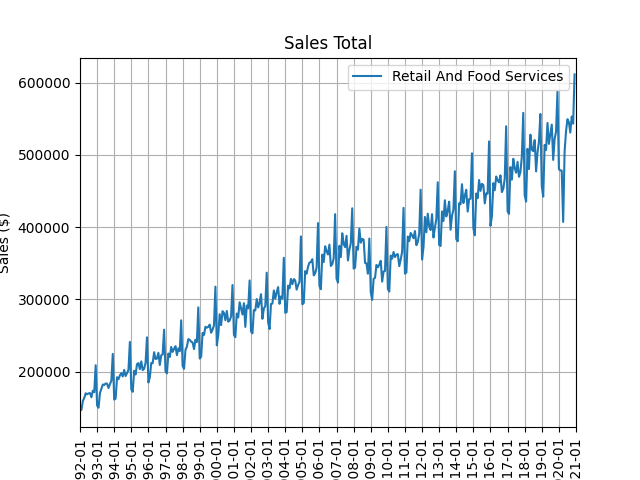

Another query that proved more useful to evidence the trend was the following:
```mysql
SELECT 
    DATE_FORMAT(Date,'%Y') as year,
    CAST(SUM(RetailAndFoodServicesSalesTotal) as UNSIGNED) as sales
FROM sales
GROUP BY year;
```
Here, the data is aggregated by year and the seasonal variability is eliminated. The graph below shows clearly that the trend is upwards for most years, but it goes down during 2008 and 2009. 

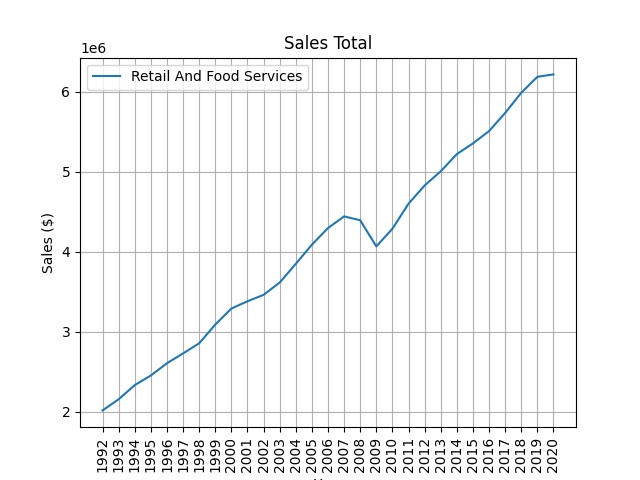

An economic trend is important because it shows whether the economy is growing or contracting.

We compared three businesses: bookstores, sporting goods stores, and hobbies, toys, and games stores. The query to pull that information was the following:

```python
# Define Query CMD
query_cmd = """
SELECT 
    DATE_FORMAT(Date,'%Y') as year,
    CAST(SUM(Bookstores) as UNSIGNED) as bookstores,
    CAST(SUM(SportingGoodsStores) as UNSIGNED) as sporting,
    CAST(SUM(HobbyToyAndGameStores) as UNSIGNED) as hobbies
FROM sales
GROUP BY year;
"""
# Execute Query
cursor.execute(query_cmd)
year = []
book = []
sport = []
hobby = []
# Save Year and Sales
for row in cursor.fetchall():
    print(row)
    year.append(row[0])
    book.append(row[1])
    sport.append(row[2])
    hobby.append(row[3])
```

The three yearly sales for each of the business was plotted using matplotlib.

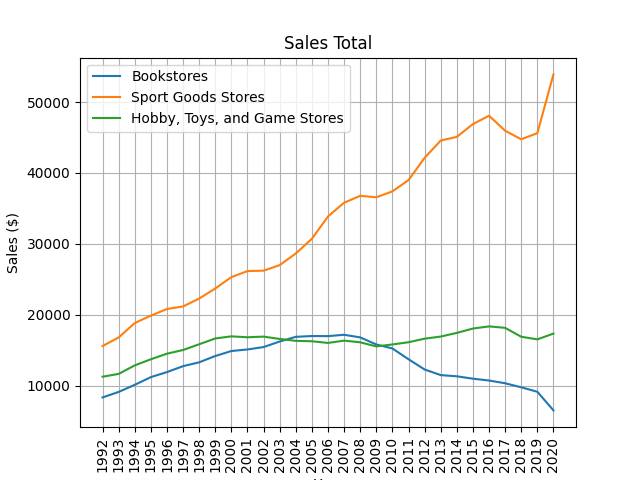

From the previos graph, the highest trend is for the Sportsgoods stores. That category is the fastest growing and is the highest (among the three). We can also observed that there changes in 2020: bookstore sales went down, sportsgoods grew strongly, and hobby stores sales went slightly up. 

The seasonal pattern can be seen by using a different query: pulling monthly data (vs. yearly one). The seasonal pattern can be visualized using the following snippet of code:

```python
dat = pd.DataFrame()
dat['date'] = [datetime.datetime.strptime(d, "%Y-%m") for d in month]
dat['year'] = [d.year for d in dat['date']]
dat['month'] = [d.strftime('%b') for d in dat['date']]
dat['book'] = book
dat['sport'] = sport
dat['hobby'] = hobby

# Box Plot
sns.boxplot(x='month', y='book', data=dat)
plt.title('Bookstore')
plt.ylabel('Sales ($)')
plt.grid()
plt.savefig('box_plot_seasonal.png')
plt.show()
```

Here we are generating a boxplot for all the Bookstore data. We are grouping data per month throughout the years and showing the results for the Bookstore data. It is clear that there is a seasonal pattern, sales increase during December, January, August, and September.

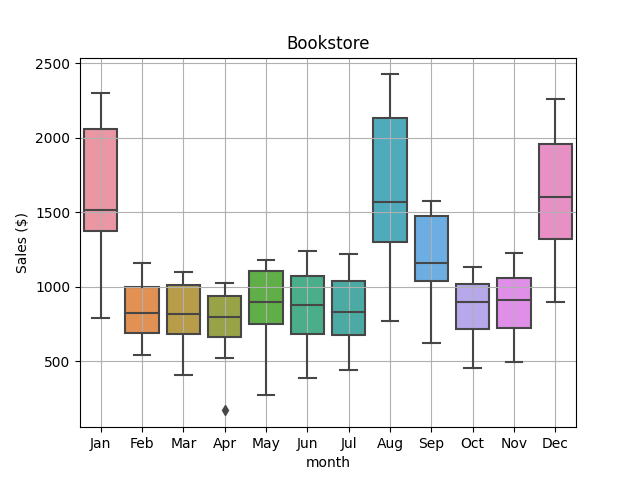

Yearly data shows different behavior from the monthly one. One is not better than the other one, but each provides different insights into the economy at different timescales.

[Back to top](#Index)

### 3.4 Explore Percentage Change

In ecnomics, the percentage change is used to calculate the rate of change of a variable over a time period. It will show how fast an economic quantify has grown/shrunk/or stay the same in a time period. For example, if the percentage change of yearly sales is +100%, that means that it has double its size in a year. It is important because it provides quantifiable information on how fast the variable is changing per unit of time.

To compare the women's clothing and men's clothing business and their percentage change, we are using the following query to pull the relevant data:

```python
# Query yearly data for men's and women's clothing stores
query_cmd = """
SELECT 
    DATE_FORMAT(Date,'%Y') as year,
    CAST(SUM(MensClothingStores) as UNSIGNED) as men,
    CAST(SUM(WomensClothingStores) as UNSIGNED) as women
FROM sales
GROUP BY year;
"""
# Execute
cursor.execute(query_cmd)
year = []
men = []
women = []

# Save Year and Sales
for row in cursor.fetchall():
    year.append(row[0])
    men.append(row[1])
    women.append(row[2])

```

The following graph shows the yearly total sales for men's and women's clothing stores. Women's clothing is around x3 bigger than the men's clothing industry.  

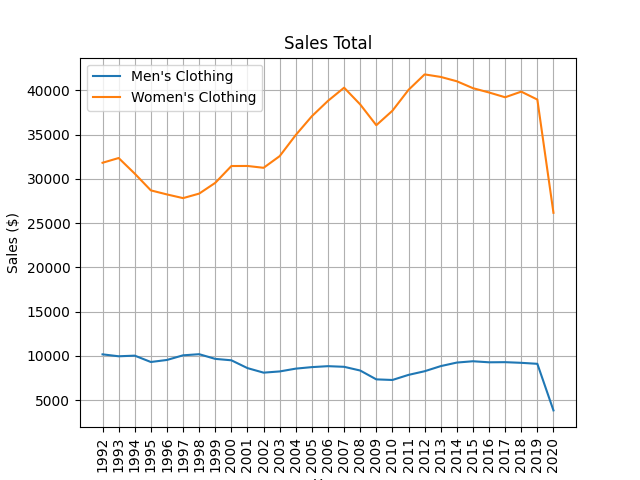



The following graph shows the percentage change across the years for the men's and women's clothing industry. Both show similar trends across the years, specifically on 2020, where there is a considerale decrease in sales for both.

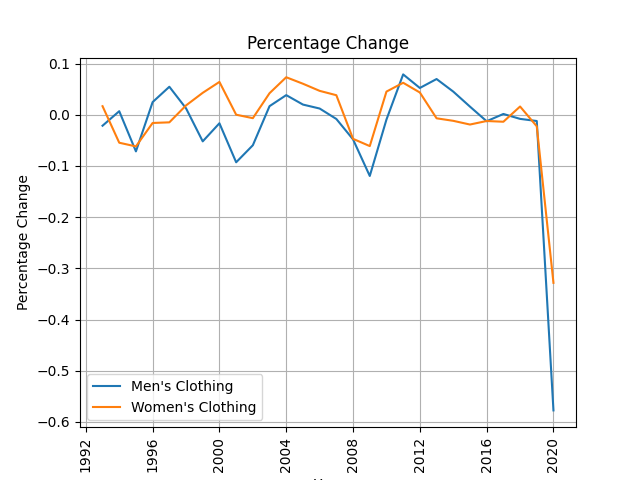



We also calculated the portion that makes up the sales for the men's clothing and women's clothing business with respect to all other business kinds. The following graph shows the percentage that the men's and women's clothing industry makes up from all the columns in the data. Each of them makes up a very small portion of the total sales in all categories. The women's clothing business makes up around 0.025%, while the men's one account for 0.01% of the total sales. The overall percentage for both industries has decreased with each year. The data is monthly so the seasonal variations can be observed as well.

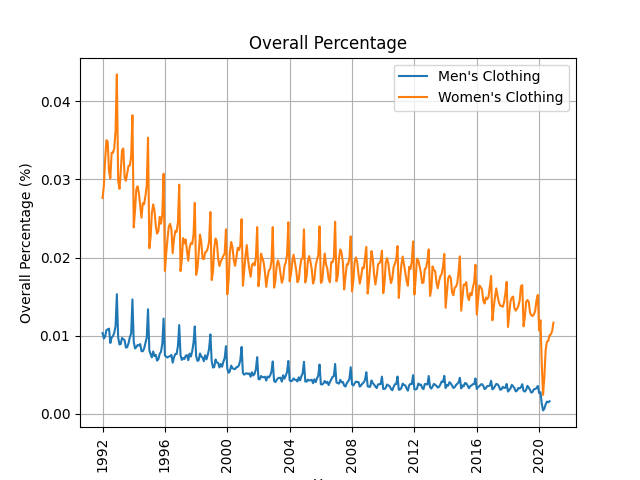

To populate the DataFrame with all the values from the database, we can use the code below.

```python
# Reading all columns from the table
query_cmd = """
SELECT 
    *
FROM sales;
"""
cursor.execute(query_cmd)
# Create DataFrame from Readout from server
data = pd.DataFrame(cursor.fetchall())
display(data)
```
We then use DataFrame manipulation techniquers to format it properly and have it ready for further analysis and visualization in Python. The following code was used to calculate the overall percentage for men's and women's clothing.

```python
# dat = DataFrame with all columns
# Convert to Float all columns but the Date
dat.loc[:, dat.columns != 'Date'] = dat.loc[:, dat.columns != 'Date'].astype(float)
# Calculate Total of all Columns (but the Date
dat['Total'] =  dat.loc[:, dat.columns != 'Date'].sum(axis=1)
# Calculate mens Percentage from Total
dat['men%'] = dat['MensClothingStores']/dat['Total']*100
# Calculate Womens Percentage from Total
dat['women%'] = dat['WomensClothingStores']/dat['Total']*100
```
We converted the data to float because we had some issues converting it to int. This is because NaN values cannot be converted to ints; they can only be converted to floats.


[Back to top](#Index)

### 3.5 Explore Rolling Time Windows

In economics, the rolling time window provides a snapshot of data to infer spending patterns (or behavior) for a specified  period (e.g., last 6 months). By changing the size of the window, we can capture the variable at different timescales. For example, if we want to understand the variability in the year, we can use the LTM (last Twelve Months). The same measure would provide no help if we want to understand seasonal patterns. So, it is critical to choose the window size according to the type of analysis we want to perform.

We selected two kinds of businesses and performed a rolling average for two periods: 12 and 3 months. The two business categories were automobile dealers and fuel dealers. The code for applying the rolling average is shown below:

```python
# Convert to Float all columns but the Date
dat.loc[:, dat.columns != 'Date'] = dat.loc[:, dat.columns != 'Date'].astype(float)
# Find the average for a rolling window of 12 and 3 months 
dat_window_12 = dat.rolling(window=12).mean()
dat_window_3 = dat.rolling(window=3).mean()

# Plot
plt.plot(dat.Date,dat_window_12['AutomobileDealers'],label="Automobile Dealers (12 months)")
plt.plot(dat.Date,dat_window_3['AutomobileDealers'],label="Automobile Dealers (3 months)")
plt.plot(dat.Date,dat_window_12['FuelDealers'],label="Fuel Dealers (12 months)")
plt.plot(dat.Date,dat_window_3['FuelDealers'],label="Fuel Dealers (3 months)")
plt.grid()
plt.xlabel('Year')
plt.ylabel('Sales ($)')
plt.title('Rollin Window')
plt.xticks(rotation = 90)
plt.legend()
plt.savefig('rolling_window.png')
plt.show()
```

The graph prodcued in shown below. We can see the difference in variability between the two different rolling windows. Varying the window size allows us to capture patterns at different timescales. We can see more variability in the 3-month window than the 12-month one.

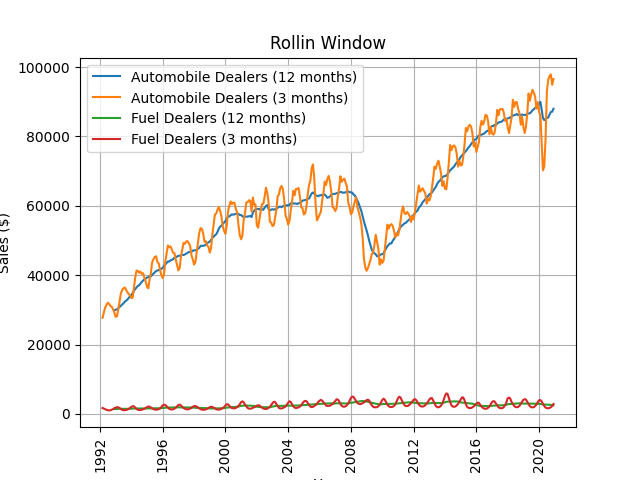

[Back to top](#Index)

## Conclusion

We started with raw data in excel format and performed multiple steps to clean and upload the data to the MYSQL database. We described the process in detail for the data pipeline. Finally, we analyzed the data, determined trends, drew conclusions on the data, and visualized relevant data characteristics. 

From the previous data considered, the automobile dealers are going to attract considerably less spending that the fuel dealers. For the case of the clothing stores, the men's clothing one will attract the least spending.

We calculated the kind of business with the most spending for yearly sales. For this, we query all the data from the database. The following code shows how the data from the query was saved as a dataframe.

```python
# Reading All Data
query_cmd = """
SELECT 
    *
FROM sales;
"""
# Execute the query
cursor.execute(query_cmd)
# Create DataFrame from Readout from server
data = pd.DataFrame(cursor.fetchall())
data = data.iloc[: , 1:]
data.columns = list(df.columns)
# Get year
data['year'] = [d.year for d in data['Date']]
# Group by year
result = data.groupby('year').aggregate('sum')
# Sort Values
df_order = result.sort_values(axis=1, ascending=False, by=2020)
```
The graph below shows the Most and Least spending category: the category with the most spending is Retail and Food Services, while Floor Covering Stores is the one with the least spending in 2020. 

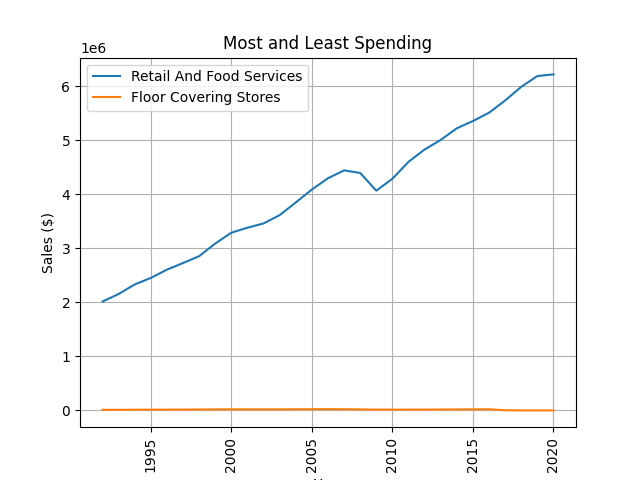



[Back to top](#Index
)
## References
- GeeksforGeeks. "Python | Pandas dataframe.pct_change()." https://www.geeksforgeeks.org/python-pandas-dataframe-pct_change/

- United States Cencus Bureau."Monthly Retail Trade." 2021. https://www.census.gov/retail/index.html

- University of Maryland. "Business Research: NAICS Codes."  https://libguides.umgc.edu/c.php?g=970568&p=7014343
